In [12]:
!pip install pymupdf pytesseract pillow sentence-transformers hdbscan umap-learn matplotlib


Extracting text and features from pages...
Computing text embeddings...
Computing text embeddings...
Clustering pages...

Detected documents and their page ranges:
Document 1: pages [0]
Document 2: pages [1]
Document 3: pages [2, 3]
Document 4: pages [4, 5]
Document 5: pages [6, 7]
Document 6: pages [8]
Document 7: pages [9, 10]
Document 8: pages [11]
Document 9: pages [12]
Document 10: pages [13, 14]
Document 11: pages [15]
Document 12: pages [16]
Document 13: pages [17, 18]
Document 14: pages [19]
Document 15: pages [20]
Document 16: pages [21, 22, 23]

Visualizing clusters with UMAP...
Clustering pages...

Detected documents and their page ranges:
Document 1: pages [0]
Document 2: pages [1]
Document 3: pages [2, 3]
Document 4: pages [4, 5]
Document 5: pages [6, 7]
Document 6: pages [8]
Document 7: pages [9, 10]
Document 8: pages [11]
Document 9: pages [12]
Document 10: pages [13, 14]
Document 11: pages [15]
Document 12: pages [16]
Document 13: pages [17, 18]
Document 14: pages [19]


c:\Users\PawanMagapalli\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\PawanMagapalli\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\PawanMagapalli\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


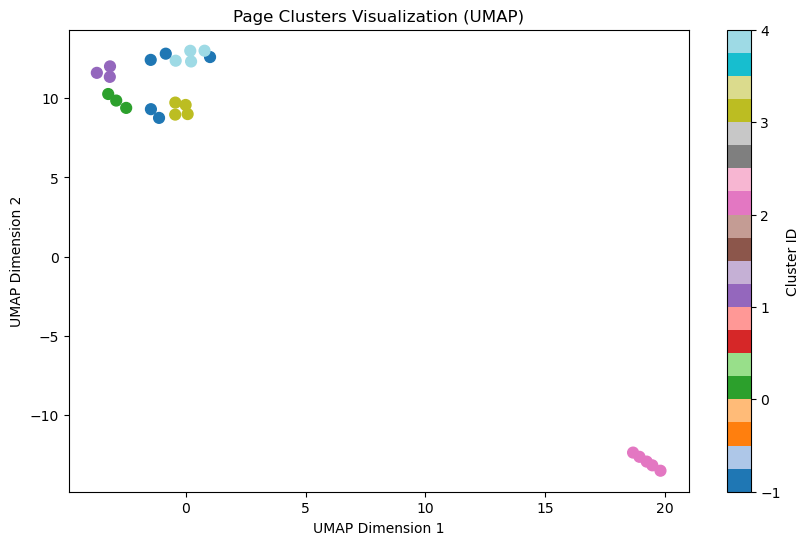

In [13]:
import fitz  # PyMuPDF
import pytesseract
from PIL import Image
from sentence_transformers import SentenceTransformer
import hdbscan
import umap
import numpy as np
import matplotlib.pyplot as plt
import re

# --- Step 1: Extract text with OCR fallback ---
def extract_text_from_page(page):
    text = page.get_text().strip()
    if len(text) < 20:  # If text is too short, try OCR
        pix = page.get_pixmap()
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        text = pytesseract.image_to_string(img)
    return text

# --- Step 2: Extract additional features from text ---
def extract_features(text):
    # Basic pattern features
    word_count = len(text.split())
    has_title = 1 if re.search(r'^[A-Z][A-Za-z\s]{3,}', text.split('\n')[0]) else 0
    has_date = 1 if re.search(r'\b\d{1,2}[-/]\d{1,2}[-/]\d{2,4}\b', text) else 0
    has_signature = 1 if re.search(r'(Sincerely|Regards|Best regards|Thank you)', text, re.I) else 0
    return np.array([word_count, has_title, has_date, has_signature])

# --- Main processing function ---
def process_pdf(pdf_path):
    # Load model for embeddings
    model = SentenceTransformer('all-MiniLM-L6-v2')

    # Open PDF
    pdf_document = fitz.open(pdf_path)

    page_texts = []
    pattern_features = []

    print("Extracting text and features from pages...")
    for i in range(len(pdf_document)):
        page = pdf_document[i]
        text = extract_text_from_page(page)
        page_texts.append(text)
        pattern_features.append(extract_features(text))

    # Get embeddings for all page texts
    print("Computing text embeddings...")
    embeddings = model.encode(page_texts)

    # Normalize pattern features and scale down to balance with embeddings
    pattern_features = np.array(pattern_features)
    pattern_features = (pattern_features - pattern_features.mean(axis=0)) / (pattern_features.std(axis=0) + 1e-6)
    pattern_features_scaled = pattern_features * 0.5  # scale factor to balance features and embeddings

    # Combine embeddings and pattern features
    combined_features = np.hstack([embeddings, pattern_features_scaled])

    # Cluster pages with HDBSCAN
    print("Clustering pages...")
    clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='euclidean')
    clusters = clusterer.fit_predict(combined_features)

    # Merge consecutive pages with same cluster label into documents
    docs = []
    current_doc = []
    current_cluster = clusters[0]

    for idx, cluster_id in enumerate(clusters):
        if cluster_id == current_cluster:
            current_doc.append(idx)
        else:
            docs.append(current_doc)
            current_doc = [idx]
            current_cluster = cluster_id
    docs.append(current_doc)

    # Print detected documents
    print("\nDetected documents and their page ranges:")
    for i, doc_pages in enumerate(docs):
        print(f"Document {i+1}: pages {doc_pages}")

    # Visualization with UMAP
    print("\nVisualizing clusters with UMAP...")
    reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='euclidean', random_state=42)
    embedding_2d = reducer.fit_transform(combined_features)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=clusters, cmap='tab20', s=60)
    plt.colorbar(scatter, label='Cluster ID')
    plt.title("Page Clusters Visualization (UMAP)")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

    return docs, clusters, page_texts

# --- Run on your PDF file ---
if __name__ == "__main__":
    pdf_path = r"C:\Users\PawanMagapalli\Downloads\document\Doc-Classification\enhanced_approach\ilovepdf_merged (1).pdf"  # Replace with your PDF path
    detected_docs, cluster_labels, texts = process_pdf(pdf_path)


Extracting text and features from pages...
Computing text embeddings...
Computing text embeddings...
Clustering pages...

Detected documents and their page ranges:
Document 1: pages [0]
Document 2: pages [1]
Document 3: pages [2, 3]
Document 4: pages [4, 5]
Document 5: pages [6, 7]
Document 6: pages [8]
Document 7: pages [9, 10]
Document 8: pages [11]
Document 9: pages [12]
Document 10: pages [13, 14]
Document 11: pages [15]
Document 12: pages [16]
Document 13: pages [17, 18]
Document 14: pages [19]
Document 15: pages [20]
Document 16: pages [21, 22, 23]

Visualizing clusters with UMAP...
Clustering pages...

Detected documents and their page ranges:
Document 1: pages [0]
Document 2: pages [1]
Document 3: pages [2, 3]
Document 4: pages [4, 5]
Document 5: pages [6, 7]
Document 6: pages [8]
Document 7: pages [9, 10]
Document 8: pages [11]
Document 9: pages [12]
Document 10: pages [13, 14]
Document 11: pages [15]
Document 12: pages [16]
Document 13: pages [17, 18]
Document 14: pages [19]


c:\Users\PawanMagapalli\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\PawanMagapalli\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\PawanMagapalli\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


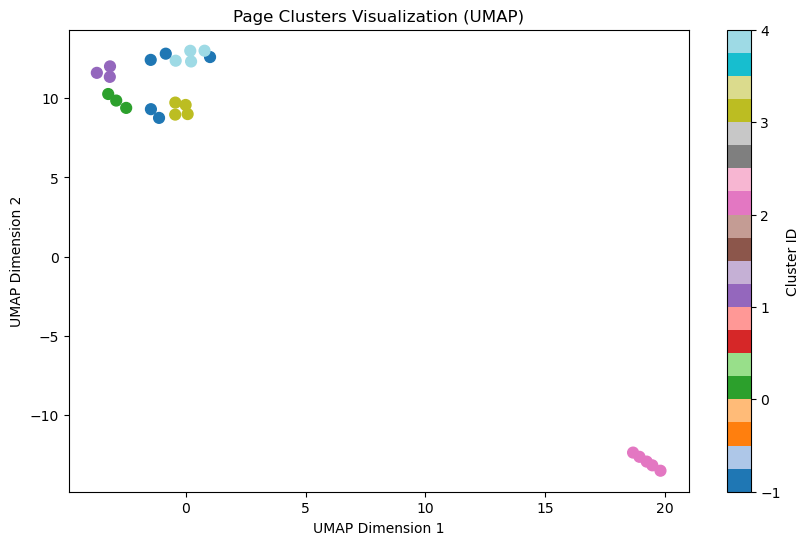

Saved: output_docs_split\document_1.pdf (pages: [0])
Saved: output_docs_split\document_2.pdf (pages: [1])
Saved: output_docs_split\document_3.pdf (pages: [2, 3])
Saved: output_docs_split\document_4.pdf (pages: [4, 5])
Saved: output_docs_split\document_5.pdf (pages: [6, 7])
Saved: output_docs_split\document_6.pdf (pages: [8])
Saved: output_docs_split\document_7.pdf (pages: [9, 10])
Saved: output_docs_split\document_8.pdf (pages: [11])
Saved: output_docs_split\document_9.pdf (pages: [12])
Saved: output_docs_split\document_10.pdf (pages: [13, 14])
Saved: output_docs_split\document_11.pdf (pages: [15])
Saved: output_docs_split\document_12.pdf (pages: [16])
Saved: output_docs_split\document_13.pdf (pages: [17, 18])
Saved: output_docs_split\document_14.pdf (pages: [19])
Saved: output_docs_split\document_15.pdf (pages: [20])
Saved: output_docs_split\document_16.pdf (pages: [21, 22, 23])


In [14]:
import os

def save_split_documents(pdf_path, docs, output_dir="output_docs_split"):
    os.makedirs(output_dir, exist_ok=True)
    pdf_document = fitz.open(pdf_path)
    for i, doc_pages in enumerate(docs):
        new_doc = fitz.open()
        for page_idx in doc_pages:
            new_doc.insert_pdf(pdf_document, from_page=page_idx, to_page=page_idx)
        output_file = os.path.join(output_dir, f"document_{i+1}.pdf")
        new_doc.save(output_file)
        new_doc.close()
        print(f"Saved: {output_file} (pages: {doc_pages})")

# Example usage after running process_pdf:
pdf_path = r"C:\Users\PawanMagapalli\Downloads\document\Doc-Classification\enhanced_approach\ilovepdf_merged (1).pdf"  # Use your PDF path
detected_docs, cluster_labels, texts = process_pdf(pdf_path)
save_split_documents(pdf_path, detected_docs)


In [15]:
# import os
# import fitz  # PyMuPDF
# import pytesseract
# from PIL import Image
# from sentence_transformers import SentenceTransformer
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.preprocessing import StandardScaler
# import umap
# import numpy as np
# import matplotlib.pyplot as plt
# import re


# def extract_text_from_page(page):
#     text = page.get_text().strip()
#     if len(text) < 20:
#         pix = page.get_pixmap()
#         img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
#         text = pytesseract.image_to_string(img)
#     return text


# def extract_features(text):
#     word_count = len(text.split())
#     first_line = text.split('\n')[0] if text else ""
#     has_title = 1 if re.search(r'^[A-Z][A-Za-z\s]{3,}', first_line) else 0
#     has_date = 1 if re.search(r'\b\d{1,2}[-/]\d{1,2}[-/]\d{2,4}\b', text) else 0
#     has_signature = 1 if re.search(r'(Sincerely|Regards|Best regards|Thank you)', text, re.I) else 0
#     return np.array([word_count, has_title, has_date, has_signature])


# def process_pdf(pdf_path):
#     model = SentenceTransformer('all-MiniLM-L6-v2')
#     pdf_document = fitz.open(pdf_path)

#     page_texts = []
#     pattern_features = []

#     print("Extracting text and features from pages...")
#     for i in range(len(pdf_document)):
#         text = extract_text_from_page(pdf_document[i])
#         page_texts.append(text)
#         pattern_features.append(extract_features(text))

#     print("Computing embeddings...")
#     embeddings = model.encode(page_texts)
#     pattern_features = np.array(pattern_features)

#     scaler = StandardScaler()
#     pattern_scaled = scaler.fit_transform(pattern_features)
#     combined_features = np.hstack([embeddings, pattern_scaled * 0.3])

#     print("Clustering pages using Agglomerative Clustering...")
#     similarity = cosine_similarity(combined_features)
    # distance = 1 - similarity
    # clustering = AgglomerativeClustering(n_clusters=None, affinity='precomputed',
    #                                      distance_threshold=0.3, linkage='average')
    # cluster_labels = clustering.fit_predict(distance)

    # docs = []
    # current_doc = []
    # current_cluster = cluster_labels[0]
    # for idx, cluster_id in enumerate(cluster_labels):
    #     if cluster_id == current_cluster:
    #         current_doc.append(idx)
    #     else:
    #         docs.append(current_doc)
    #         current_doc = [idx]
    #         current_cluster = cluster_id
    # docs.append(current_doc)

    # print("\nDetected document boundaries:")
    # for i, doc_pages in enumerate(docs):
    #     print(f"Document {i+1}: Pages {doc_pages}")

    # print("Generating UMAP visualization...")
    # reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='cosine', random_state=42)
    # embedding_2d = reducer.fit_transform(combined_features)

    # plt.figure(figsize=(12, 7))
    # scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=cluster_labels, cmap='tab10', s=80)
    # for i, txt in enumerate(range(len(page_texts))):
    #     plt.annotate(str(i), (embedding_2d[i, 0], embedding_2d[i, 1]))
    # plt.colorbar(scatter, label='Cluster ID')
    # plt.title("Page Clusters (UMAP + Agglomerative Clustering)")
    # plt.xlabel("UMAP 1")
#     plt.ylabel("UMAP 2")
#     plt.show()

#     return docs, cluster_labels, page_texts


# def save_split_documents(pdf_path, docs, output_dir="output_docs_split"):
#     os.makedirs(output_dir, exist_ok=True)
#     pdf_document = fitz.open(pdf_path)
#     output_files = []
#     for i, doc_pages in enumerate(docs):
#         new_doc = fitz.open()
#         for page_idx in doc_pages:
#             new_doc.insert_pdf(pdf_document, from_page=page_idx, to_page=page_idx)
#         output_file = os.path.join(output_dir, f"document_{i+1}.pdf")
#         new_doc.save(output_file)
#         new_doc.close()
#         output_files.append((output_file, doc_pages))
#         print(f"Saved: {output_file} (pages: {doc_pages})")
#     return output_files


# # --- Run the tool ---
# if __name__ == "__main__":
#     pdf_path = r"C:\Users\PawanMagapalli\Downloads\document\Doc-Classification\merged doc.pdf"
#     detected_docs, cluster_labels, texts = process_pdf(pdf_path)
#     save_split_documents(pdf_path, detected_docs)
